In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft
import lightgbm as lgb
from lightgbm import plot_tree
from graphviz import Digraph
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import time
import pickle

%matplotlib inline

# Load Original Features

In [3]:
feat_num = 457

In [4]:
#df_total_raw = pd.read_csv('./data/features%s.csv'%(feat_num))
with open('./data/features%s.pickle'%(feat_num), 'rb') as handle:
    df_total_raw = pickle.load(handle)

In [5]:
#to_drop = ['card1_count','addr2','V117','V118','V120','V122','id_25','id_21','id_26',
#           'V305','id_17','V27','V28','V88','V89','id_14','V107','V240','V241','V41','id_24','V68']
to_drop = ['C8']
#with open('./data/feat%s_rm_pm_importance0.pickle'%(feat_num), 'rb') as handle:
#    to_drop = pickle.load(handle)

In [6]:
df_total = df_total_raw.drop(to_drop,axis=1)
#df_total = df_total_raw

In [7]:
features_train = df_total[df_total['isFraud'].notnull()]
features_test = df_total[df_total['isFraud'].isnull()]

In [8]:
labels_train = features_train['isFraud']
features_train = features_train.drop(columns = ['isFraud', 'TransactionID'])

In [9]:
features_train.shape

(590540, 454)

# Prepare model

In [10]:
categorical = ['ProductCD', 'card2', 'card3', 'card4', 'card5','card6',
              'addr1','addr2','P_email','R_email','M1','M2','M3',
              'M4','M5','M6','M7','M8','M9','DeviceType','DeviceInfo','dow','hour',
              'Device_name','Device_version','screen_width','screen_height',
               'P_email_suffix','R_email_suffix','id_30_OS','id_30_version',
              'is_card_freq_Device','is_wide','is_long','is_zero','is_win8_vista',
              'is_windows_otheros','is_card_freq_pdc','is_card_freq_addr1'] 
ids = [ 'id_%s'%(i) for i in range(12,39)]
categorical = categorical + ids

In [11]:
categorical = list(set(categorical).intersection(df_total.columns))

In [12]:
features_test_new = features_test.drop(columns = ['isFraud', 'TransactionID'])

In [13]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type":"gbdt" ,#'goss'
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
          'num_threads':5
          #'device' :'gpu',
          #'is_unbalance':True
          #'scale_pos_weight':9
         }

# Feature Selection

In [29]:
features_train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_02_to_std_card1,D15_to_mean_card1,D15_to_std_card1,D15_to_mean_addr1,D15_to_std_addr1,TransactionAmt_decimal,Device_name,Device_version,screen_width,screen_height
0,86400,68.5,0,13926,NaN,150.0,0,142.0,0,315.0,...,NaN,0.000000,0.000000,0.000000,0.000000,500,-1,-1,-1,-1
1,86401,29.0,0,2755,404.0,150.0,1,102.0,0,325.0,...,NaN,0.000000,0.000000,0.000000,0.000000,0,-1,-1,-1,-1
2,86469,59.0,0,4663,490.0,150.0,2,166.0,1,330.0,...,NaN,2.188598,1.578656,1.420777,1.251501,0,-1,-1,-1,-1
3,86499,50.0,0,18132,567.0,150.0,1,117.0,1,476.0,...,NaN,0.471748,0.434842,0.581165,0.474049,0,-1,-1,-1,-1
4,86506,50.0,1,4497,514.0,150.0,1,102.0,0,420.0,...,0.9245,NaN,NaN,NaN,NaN,0,0,0,0,0


In [57]:
start = time.time()
train_set = lgb.Dataset(features_train.iloc[0:472432,:], label=labels_train.values[0:472432],categorical_feature=categorical)#
valid_set = lgb.Dataset(features_train.iloc[472432:,:], label=labels_train.values[472432:],categorical_feature=categorical)#
valid_results = {}
model = lgb.train(params,train_set,num_boost_round = 10000, 
                  valid_sets = [train_set, valid_set],
                  verbose_eval=500,
                  early_stopping_rounds = 500,
                  evals_result=valid_results)
print(time.time()-start)

/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.988047	valid_1's auc: 0.920782
[1000]	training's auc: 0.998515	valid_1's auc: 0.928103
[1500]	training's auc: 0.999876	valid_1's auc: 0.928945
[2000]	training's auc: 0.999994	valid_1's auc: 0.92944
[2500]	training's auc: 1	valid_1's auc: 0.929785
[3000]	training's auc: 1	valid_1's auc: 0.929871
Early stopping, best iteration is:
[2711]	training's auc: 1	valid_1's auc: 0.930052
920.2465305328369


In [15]:
max(valid_results['valid_1']['auc'])

0.9299156785252384

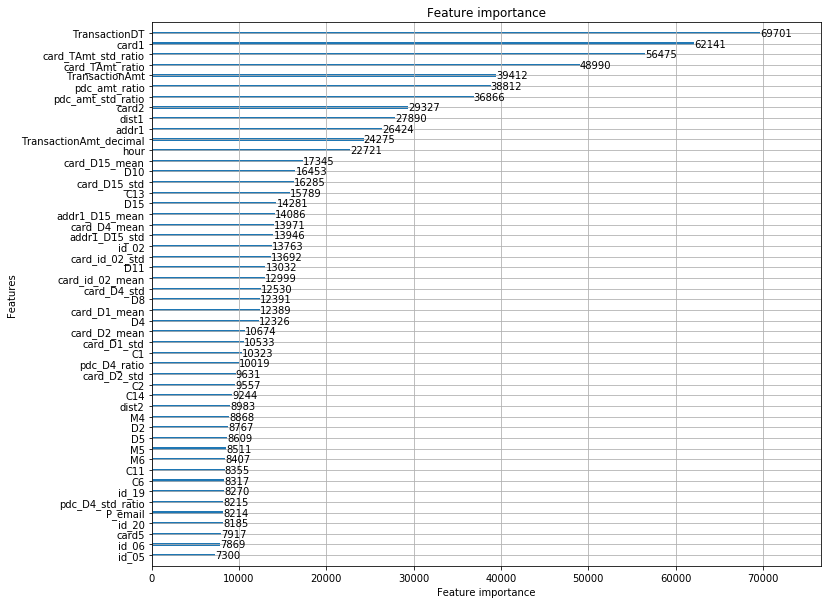

In [60]:
lgb.plot_importance(model, max_num_features=50,figsize=(12,10))

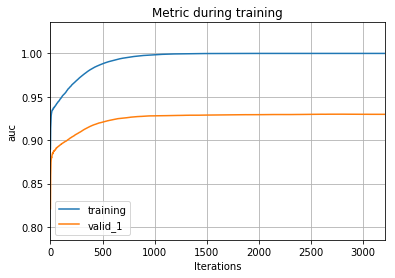

In [59]:
#lgb.plot_split_value_histogram(model, feature='dist1', bins='auto')
lgb.plot_metric(valid_results, metric='auc')

In [ ]:
lgb.plot_tree(model,tree_index=0, figsize=(107,105))

In [29]:
graph = lgb.create_tree_digraph(model, tree_index=0, name='Tree0')
graph.render(view=True)

'Tree0.gv.pdf'

# Train Model

In [14]:
splits = 5
folds = KFold(n_splits = splits,random_state=50)
predictions = np.zeros(len(features_test_new))
ave_auc = 0

In [15]:
for fold_num, (trn_idx, val_idx) in enumerate(folds.split(features_train.values, 
                                                          labels_train.values)):
    print("Fold {}".format(fold_num))
    train_df, y_train_df = features_train.iloc[trn_idx], labels_train.iloc[trn_idx]
    valid_df, y_valid_df = features_train.iloc[val_idx], labels_train.iloc[val_idx]
    
    trn_data = lgb.Dataset(train_df, label=y_train_df,categorical_feature=categorical)
    val_data = lgb.Dataset(valid_df, label=y_valid_df,categorical_feature=categorical)
    
    valid_results = {}
    clf = lgb.train(params,
                    trn_data,
                    10000,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds=500,
                   evals_result=valid_results)
    
    pred = clf.predict(valid_df)
    auc_score = roc_auc_score(y_valid_df, pred)
    ave_auc += auc_score / splits
    predictions += clf.predict(features_test_new) / splits

Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986683	valid_1's auc: 0.907119
[1000]	training's auc: 0.998146	valid_1's auc: 0.917926
[1500]	training's auc: 0.999821	valid_1's auc: 0.920876
[2000]	training's auc: 0.99999	valid_1's auc: 0.921933
[2500]	training's auc: 1	valid_1's auc: 0.922423
[3000]	training's auc: 1	valid_1's auc: 0.922648
[3500]	training's auc: 1	valid_1's auc: 0.922931
Early stopping, best iteration is:
[3231]	training's auc: 1	valid_1's auc: 0.922827
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.98763	valid_1's auc: 0.929021
[1000]	training's auc: 0.998509	valid_1's auc: 0.936663
[1500]	training's auc: 0.999881	valid_1's auc: 0.937725
[2000]	training's auc: 0.999994	valid_1's auc: 0.937387
Early stopping, best iteration is:
[1700]	training's auc: 0.999961	valid_1's auc: 0.937788
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.988164	valid_1's auc: 0.927132
[1000]	training's auc: 0.998548	valid_1's auc: 0.933414
[1500]	training's auc: 0.999881	valid_1's auc: 0.933592
Early stopping, best iteration is:
[1172]	training's auc: 0.999342	valid_1's auc: 0.93368
Fold 3


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.987679	valid_1's auc: 0.944327
[1000]	training's auc: 0.998527	valid_1's auc: 0.951874
[1500]	training's auc: 0.999882	valid_1's auc: 0.952617
[2000]	training's auc: 0.999995	valid_1's auc: 0.952676
Early stopping, best iteration is:
[1809]	training's auc: 0.999981	valid_1's auc: 0.952746
Fold 4


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.987875	valid_1's auc: 0.921598
[1000]	training's auc: 0.99854	valid_1's auc: 0.929044
[1500]	training's auc: 0.999883	valid_1's auc: 0.929451
[2000]	training's auc: 0.999995	valid_1's auc: 0.929961
[2500]	training's auc: 1	valid_1's auc: 0.930223
[3000]	training's auc: 1	valid_1's auc: 0.93032
Early stopping, best iteration is:
[2877]	training's auc: 1	valid_1's auc: 0.930374


In [16]:
# # feat 457 drop c8
ave_auc

0.9354828335082059

In [19]:
# feat 457 all features
ave_auc

0.9352800271384787

In [44]:
###### drop using feat476_rm_pm_importance0
ave_auc

0.9352034490404105

In [15]:
# with all features
ave_auc

0.9351542303135258

In [27]:
# drop one feature v91
ave_auc

0.9355613734574988

In [17]:
id_test = features_test['TransactionID']
submission = pd.DataFrame({'TransactionID': id_test, 
                            'isFraud': predictions})
submission.to_csv('./data/sub_feat%s_rm_c8.csv'%(feat_num), index = False)